In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'D:\Anna\VE\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
df = pd.read_excel('apps_event.xlsx')

In [4]:
df

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads
...,...,...,...,...,...,...,...,...
441980,2020-01-15,tap_basket,NaN,ios,8700975,female,Moscow,vk_ads
441981,2020-01-15,tap_basket,NaN,android,2531506,male,Saint-Petersburg,-
441982,2020-01-15,tap_basket,NaN,ios,6525227,female,Moscow,-
441983,2020-01-15,tap_basket,NaN,android,17844257,male,Saint-Petersburg,-


In [5]:
df.describe()

,purchase_sum,device_id
count,29222.000000,4.419850e+05
mean,700.704178,1.138785e+07
std,1272.876396,9.833025e+06
min,61.000000,4.013000e+03
25%,226.500000,2.480060e+06
50%,393.000000,9.285113e+06
75%,559.500000,1.800544e+07
max,7883.500000,3.472695e+07


In [6]:
df.dtypes

date            datetime64[ns]
event                   object
purchase_sum           float64
os_name                 object
device_id                int64
gender                  object
city                    object
utm_source              object
dtype: object

# Retention Rate

In [7]:
#Возьмём дату, когда пользователь впервые проявил активность
first_session_date_by_customers = df.groupby('device_id')['date'].min()

In [8]:
first_session_date_by_customers

device_id
4013       2020-01-15
4014       2020-01-02
4016       2020-01-04
4046       2020-01-04
4060       2020-01-03
              ...    
34715617   2020-01-15
34717233   2020-01-15
34718714   2020-01-14
34723669   2020-01-15
34726946   2020-01-15
Name: date, Length: 64372, dtype: datetime64[ns]

In [9]:
first_session_date_by_customers.name = "first_session_date" # добавим новый столбец с датой, когда пользователь зашел в приложение  

In [10]:
visits = df.join(first_session_date_by_customers, on ='device_id')

In [11]:
visits.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,first_session_date
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-01
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,2020-01-01
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,2020-01-01


In [12]:
visits.dtypes

date                  datetime64[ns]
event                         object
purchase_sum                 float64
os_name                       object
device_id                      int64
gender                        object
city                          object
utm_source                    object
first_session_date    datetime64[ns]
dtype: object

In [13]:
visits['cohort_lifetime'] = visits['date'] - visits['first_session_date']
visits.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,first_session_date,cohort_lifetime
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-01,0 days
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01,0 days
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,2020-01-01,0 days
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01,0 days
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,2020-01-01,0 days


In [14]:
#группируем данные по когорте пользователей и lifetime
cohorts = visits.groupby(['first_session_date', 'cohort_lifetime']).agg({'device_id': 'nunique'}).reset_index()
cohorts

,first_session_date,cohort_lifetime,device_id
0,2020-01-01,0 days,4445
1,2020-01-01,1 days,1211
2,2020-01-01,2 days,1257
3,2020-01-01,3 days,1154
4,2020-01-01,4 days,1271
...,...,...,...
115,2020-01-13,1 days,644
116,2020-01-13,2 days,430
117,2020-01-14,0 days,6415
118,2020-01-14,1 days,660


In [15]:
#Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю
initial_users_count = cohorts[cohorts['cohort_lifetime']== '0 days'][['first_session_date', 'device_id']]
initial_users_count = initial_users_count.rename(columns={'device_id': 'cohort_users'})

In [17]:
#Объединим данные по когортам с исходным количеством пользователей в когорте
cohorts = cohorts.merge(initial_users_count, on='first_session_date')

In [18]:
cohorts['retention'] = cohorts['device_id']/cohorts['cohort_users_x']

In [19]:
retention_pivot = cohorts.pivot_table(index='first_session_date', columns='cohort_lifetime',
                                      values='retention', aggfunc='sum')
retention_pivot.round(3).fillna('')

cohort_lifetime,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,10 days,11 days,12 days,13 days,14 days
first_session_date,,,,,,,,,,,,,,,
2020-01-01,1.0,0.272,0.283,0.26,0.286,0.262,0.246,0.261,0.255,0.3,0.299,0.276,0.269,0.256,0.241
2020-01-02,1.0,0.231,0.229,0.269,0.226,0.205,0.211,0.215,0.269,0.255,0.228,0.217,0.211,0.215,
2020-01-03,1.0,0.195,0.238,0.171,0.159,0.168,0.157,0.229,0.212,0.184,0.179,0.166,0.166,,
2020-01-04,1.0,0.217,0.166,0.138,0.149,0.143,0.205,0.189,0.173,0.164,0.148,0.142,,,
2020-01-05,1.0,0.184,0.136,0.136,0.136,0.194,0.174,0.148,0.143,0.127,0.135,,,,
2020-01-06,1.0,0.131,0.133,0.122,0.17,0.172,0.145,0.144,0.127,0.115,,,,,
2020-01-07,1.0,0.129,0.126,0.14,0.136,0.112,0.12,0.109,0.11,,,,,,
2020-01-08,1.0,0.156,0.185,0.162,0.147,0.12,0.117,0.112,,,,,,,
2020-01-09,1.0,0.274,0.221,0.162,0.147,0.125,0.118,,,,,,,,


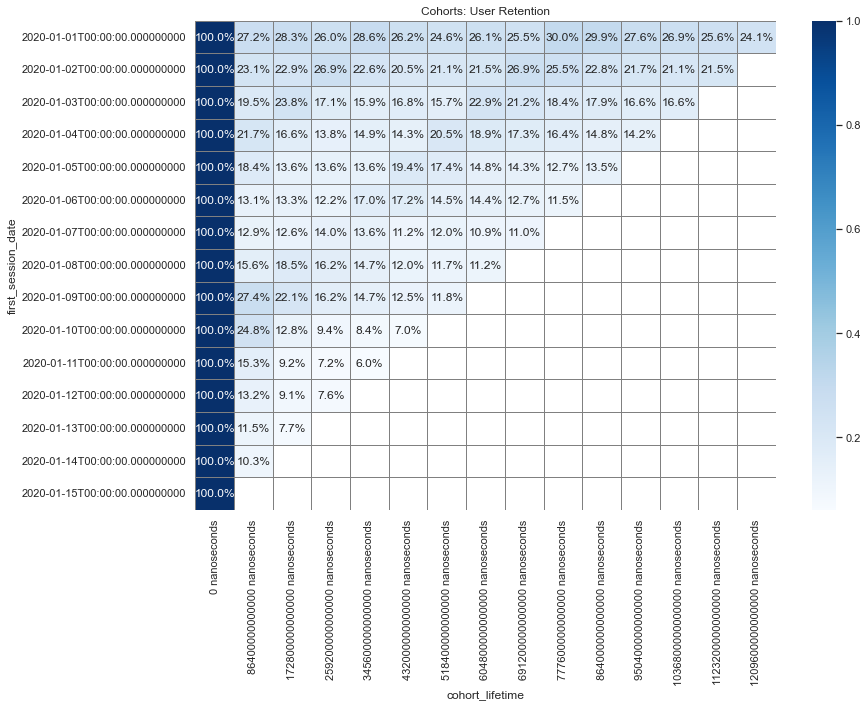

In [20]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap = 'Blues');